## Coordinate aliasing

When loading volumetric data into yt from xarray, there are a number of situations that may need some extra handling. 

1. The first situation is when the data contain a time dimensions (as is common in many cf-compliant netcdfs). In this case, we'll need to select the time to load into yt. 
2. It is also possible that the coordinates for a variable may not be recognized by yt, in which case we need to tell yt how to interpret those coordinates. 


We'll demonstrate this once again using random data:

In [1]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray.sample_data import load_random_xr_data

fields = {'temp': ('h1', 'b2', 'c1'), 
          'precip': ('h1', 'b2'),
          'precip_t': ('h1', 'b2', 'time')}
dims = {'h1': (0,1,15), 'b2': (0, 1, 10), 'c1': (0, 1, 15), 'time': (0, 1, 5)}
ds = load_random_xr_data(fields, dims, length_unit='m')

because these coordinates do not match up with those used by yt, simply trying

```python
yt_ds = ds.yt.load_uniform_grid(fields=['temp'])
```

will result in the following error:

```
ValueError: h1 is not a known coordinate. To load in yt, you must supply an alias via the yt_xarray.known_coord_aliases dictionary.
```
This is telling us that to load data into yt, we need to explain how to map our dimension names to those expected by yt. 

If our dataset is cartesian, we can do so by adding some mappings to the `yt_xarray.known_coord_aliases` dictionary. The keys here are your native dataset names, while the values are the expected yt name:

In [2]:
yt_xarray.known_coord_aliases['h1'] = 'y'
yt_xarray.known_coord_aliases['b2'] = 'x'
yt_xarray.known_coord_aliases['c1'] = 'z'

now we can load up the data:

In [3]:
yt_ds = ds.yt.load_grid(fields=['temp'])

yt_xarray : [INFO ] 2023-02-06 12:24:30,361:  Inferred geometry type is cartesian. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2023-02-06 12:24:30,362:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 12:24:30,363:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt : [INFO     ] 2023-02-06 12:24:30,452 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 12:24:30,454 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-02-06 12:24:30,456 Parameters: domain_left_edge          = [-0.03571429 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 12:24:30,457 Parameters: domain_right_edge         = [1.03571429 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 12:24:30,458 Parameters: cosmological_simulation   = 0


Note that from here, you'll have to use the yt name within yt commands:

yt : [INFO     ] 2023-02-06 12:24:30,593 xlim = -0.055556 1.055556
yt : [INFO     ] 2023-02-06 12:24:30,593 ylim = -0.035714 1.035714
yt : [INFO     ] 2023-02-06 12:24:30,594 xlim = -0.055556 1.055556
yt : [INFO     ] 2023-02-06 12:24:30,595 ylim = -0.035714 1.035714
yt : [INFO     ] 2023-02-06 12:24:30,600 Making a fixed resolution buffer of (('stream', 'temp')) 800 by 800



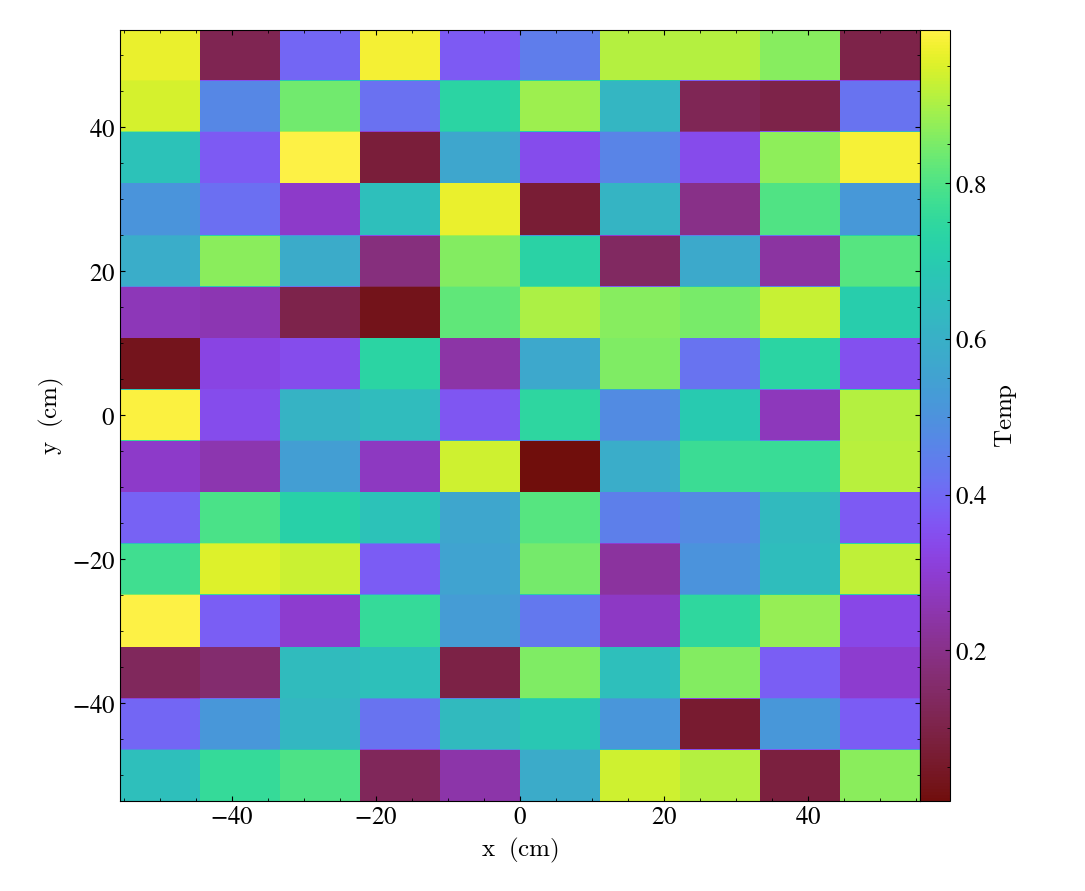

In [4]:
slc = yt.SlicePlot(yt_ds, 'z', ('stream', 'temp'))
slc.set_log(('stream', 'temp'), False)